# DeepLabv3 transfer learning implementation


## Import pretrained model Deeplabv3

In [1]:
from torch.utils.data import Dataset
import torchvision.transforms.functional as F
import torch
import os

# os.environ['CUDA_LAUNCH_BLOCKING']='1'

%matplotlib widget

from utils.function_lib import *
from utils.LiverDataset import *
from utils.DiceLoss import *

from ModelBuilder.ResNet152_DeepLab import ResNet152DeepLab
from ModelBuilder.ResNeXt101_DeepLab import ResNeXt101DeepLab
from ModelBuilder.DenseNet.DenseNet201_DeepLab import DenseNet201DeepLab
from ModelBuilder.Inception.InceptionV3_DeepLab import InceptionV3DeepLab
from ModelBuilder.ConvNeXt.ConvNeXt_DeepLab import ConvNeXtDeepLab
from ModelBuilder.unet import UNet

from FusionSystem.FusionNetwork import FusionNetwork

In [2]:
transform_image = transforms.Compose(
    [
     transforms.ToPILImage(),
     transforms.Resize(256, interpolation=transforms.functional.InterpolationMode.BILINEAR, antialias = True),
     transforms.ToTensor(),
     transforms.Normalize(mean=[0.2], std=[0.2])
     ])
transform_mask = transforms.Compose(
    [
     transforms.ToTensor()
     ])

path = 'G:/MachineLearning/liver-database/'
save_path = 'G:/MachineLearning/models/'
#path = 'segmentations/'
dataset_learn = LiverDataset(path + 'validation/', transform_image=transform_image, transform_mask=transform_mask)
dataloader_learn = torch.utils.data.DataLoader(dataset_learn, batch_size=2, shuffle=True, num_workers=8)

## Vizualizam o imagine din dataset

In [3]:
model = FusionNetwork('G:/MachineLearning/models/')
device = torch.device('cpu')
model.to(device)
model.eval()


FusionNetwork(
  (resnet): ResNet152DeepLab(
    (FeatureExtractor): IntermediateLayerGetter(
      (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_sta

torch.Size([1, 1, 256, 256])
torch.Size([512, 512])
tensor(1.)


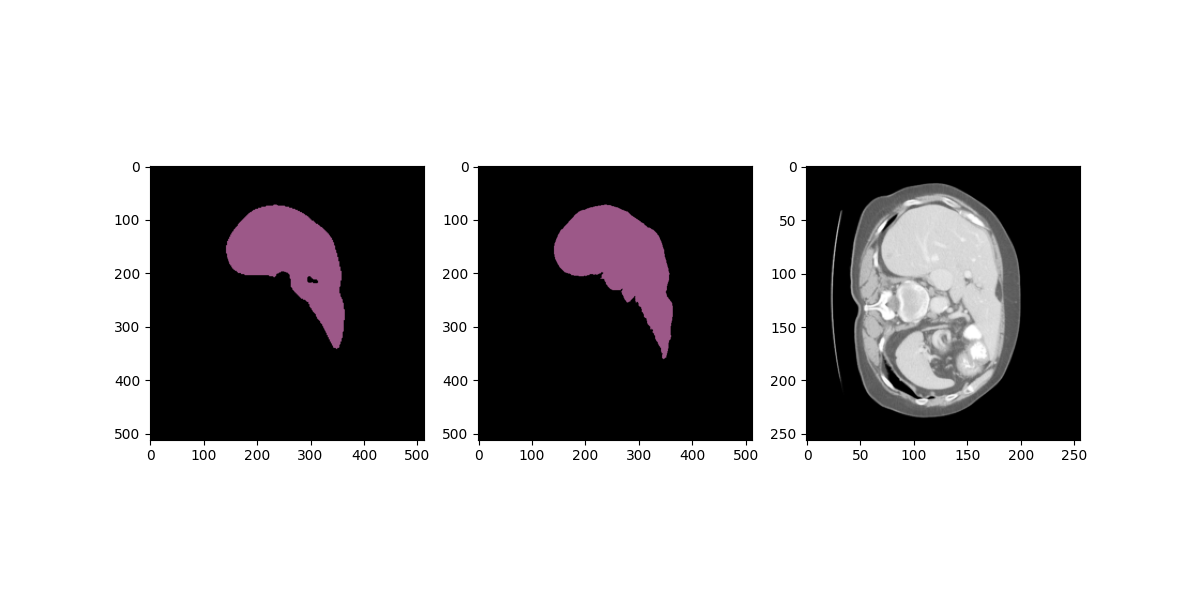

In [4]:
show_model_seg(model, dataset_learn, 60)
